# Определение возраста покупателей

## Исследовательский анализ данных

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [6]:
labels.head(5)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [7]:
labels.info

<bound method DataFrame.info of        file_name  real_age
0     000000.jpg         4
1     000001.jpg        18
2     000002.jpg        80
3     000003.jpg        50
4     000004.jpg        17
...          ...       ...
7586  007608.jpg        14
7587  007609.jpg        37
7588  007610.jpg        28
7589  007611.jpg        20
7590  007612.jpg        47

[7591 rows x 2 columns]>

In [3]:
print("Размер выборки:", len(labels))

Размер выборки: 7591


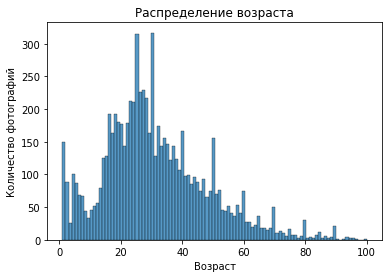

In [4]:
sns.histplot(labels['real_age'], bins=100)
plt.title('Распределение возраста')
plt.xlabel('Возраст')
plt.ylabel('Количество фотографий')
plt.show()

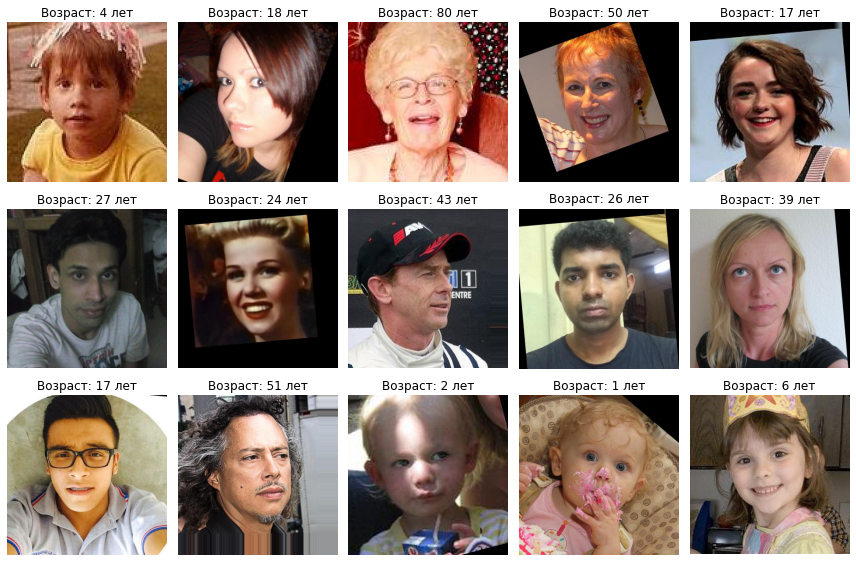

In [5]:
fig, ax = plt.subplots(3, 5, figsize=(12, 8))
ax = ax.ravel()
for i in range(15):
    img_path = os.path.join('/datasets/faces/final_files/', labels.loc[i, 'file_name'])
    img = Image.open(img_path)
    ax[i].imshow(img)
    ax[i].set_title(f"Возраст: {labels.loc[i, 'real_age']} лет")
    ax[i].axis('off')
plt.tight_layout()
plt.show()

На основе анализа были сделаны следующие выводы:
- В выборке 7591 фотография
- Датасет устроен в формате двух столбцов - с фотографией и возрастом. 
- На графике можно заметить нормальное распределение со смещением влево (в выборке преобладают изображения с людьми молодого возраста, это может привести к меньшей точности модели по отношению к фотографиям с людьми старшего возраста)
- Вероятно, изображения были приведены в вертикальное положение и +- к одному размеру лиц.
- Сами фотографии разного качества, разной яркости, некоторые из них обрезаны, повернуты или имеют сдвиг.

## Обучение модели

(Код в этом разделе запускался в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def load_train(path):
    data=pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,rescale=1/255, horizontal_flip=True) 
    train_datagen_flow = train_datagen.flow_from_dataframe(
                                    dataframe=data,
                                    directory=path + '/final_files',
                                    x_col='file_name',
                                    y_col='real_age',
                                    target_size=(224, 224),
                                    batch_size=32,
                                    class_mode='raw',
                                    subset='training',
                                    seed=12345)  
    return train_datagen_flow

def load_test(path):
    data=pd.read_csv(path + '/datasets/faces/labels.csv')
    validation_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
    val_datagen_flow = validation_datagen.flow_from_dataframe(
                                    dataframe=data,
                                    directory=path + '/datasets/faces/final_files',
                                    x_col='file_name',
                                    y_col='real_age',
                                    target_size=(224, 224),
                                    batch_size=32,
                                    class_mode='raw',
                                    subset='validation',
                                    seed=12345)
    return val_datagen_flow

def create_model(input_shape):
    optimizer = Adam(lr=0.0001)

    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])

    return model    
    
def train_model(model, train_data, test_data, batch_size=None, epochs=3,
               steps_per_epoch=None, validation_steps=0.005):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,validation_data=(test_data),
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)  

    return model

```

Train for 178 steps, validate for 60 steps
Epoch 1/5

178/178 - 73s - loss: 268.6575 - mae: 11.6304 - val_loss: 731.9367 - val_mae: 22.1137
Epoch 2/5
178/178 - 39s - loss: 78.5087 - mae: 6.6642 - val_loss: 565.7109 - val_mae: 18.4996
Epoch 3/5
178/178 - 39s - loss: 50.0589 - mae: 5.3552 - val_loss: 277.4107 - val_mae: 12.3118
Epoch 4/5
178/178 - 39s - loss: 34.4343 - mae: 4.4944 - val_loss: 119.2103 - val_mae: 8.4448
Epoch 5/5
178/178 - 39s - loss: 27.8191 - mae: 4.0001 - val_loss: 78.8557 - val_mae: 6.7753
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 78.8557 - mae: 6.7753
Test MAE: 6.7753

В результате работы модели получили значение MAE, равное 6,8. Такой результат для нашего исследования можно считать валидным.

## Анализ обученной модели

ResNet хорошо справилась с задачей определения возраста:
- Ошибка 6,8 (в данном случае) свидетельствует о том, что данную модель можно применять в большинстве ситуаций, когда нужно узнать приблизительный возраст клиента/посетителя. Например, в интим-магазине (если магазину нужен миинмальный возрастной порог), при покупке клиентом алкоголя (также как условное подтверждение совершеннолетия) или для дальнейших рекомендаций клиенту в комбинации с другими моделями (например, если для аутентификации в интернет-магазине клиент не загрузил данные о возрасте, но загрузил свою фотографию).